<a href="https://colab.research.google.com/github/rajaranjith/HCL-DL-Training/blob/master/Gen%20AI%20Application%20Developer%20FY%E2%80%9926%20Batch-2%20-%2015Sep%20to%2019Nov2025%20-%20till%2024Sep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code and o/p for Assignment on 22Sep2025:
build a linear regression model for the salary data given above and predict the salary for a given input, and also print 10 testcase outputs

In [8]:
!pip install langchain langchain-core langchain-community langchain-huggingface langchain-text-splitters
!pip install transformers sentence-transformers accelerate bitsandbytes
!pip install chromadb
!pip install pypdf
!pip install --upgrade langchain langchain-core langchain-community

In [19]:
# ---- Imports
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
import shutil
from pathlib import Path
import torch
from google.colab import files

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import BitsAndBytesConfig

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

ModuleNotFoundError: No module named 'langchain.chains'

In [1]:
# ===========================================
# RAG PDF Summarizer (Open-Source LLM + ChromaDB) for Google Colab
# ===========================================
# What this cell does:
# 1) Installs dependencies (LangChain, Chroma, Transformers, SentenceTransformers)
# 2) Loads a small open-source instruction-tuned model (default: microsoft/Phi-3-mini-4k-instruct)
# 3) Lets you upload a PDF
# 4) Builds a Chroma vector store with sentence-transformer embeddings
# 5) Runs a RAG chain to summarize the entire document with citations to pages
# 6) Saves and downloads summary.md
#
# No OpenAI is used. Everything is open-source.
# ===========================================

# ---- Fix for numpy binary incompatibility error
# Uninstall existing numpy and install a compatible version
# Then reinstall other packages to ensure compatibility.
#!pip uninstall -y numpy
#!pip install numpy # Install a version compatible with the current environment

# Uninstall torch before reinstalling other packages, as it is a major dependency often causing numpy issues
#!pip uninstall -y torch

# ---- Install libs with --force-reinstall to ensure compatibility with the new numpy
#!pip -q install --force-reinstall -U "langchain>=0.2,<0.3" "langchain-community>=0.2,<0.3" "langchain-text-splitters>=0.2,<0.3" langchain-huggingface
#!pip -q install --force-reinstall -U chromadb pypdf sentence-transformers
#!pip -q install --force-reinstall -U "transformers>=4.44" accelerate bitsandbytes

!pip install langchain
!pip install langchain_community
!pip install langchain-text-splitters

!pip install sentence-transformers
!pip install transformers accelerate bitsandbytes

!pip install chromadb
!pip install pypdf

# ---- Imports
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
import shutil
from pathlib import Path
import torch
from google.colab import files

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import BitsAndBytesConfig

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

!pip install langchain-huggingface
from langchain_huggingface import HuggingFacePipeline
!pip install --upgrade langchain langchain-core langchain_community
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

# ---- Configuration (you can tweak these)
MODEL_ID = "microsoft/Phi-3-mini-4k-instruct"   # small + good quality; alternatives in comments below
# Other good small open instruct models:
#   "Qwen/Qwen2.5-1.5B-Instruct"        (multilingual, small)
#   "google/gemma-2-2b-it"              (note license constraints for some use cases)
#   "TinyLlama/TinyLlama-1.1B-Chat-v1.0" (very small; lower quality)
MAX_NEW_TOKENS = 800
TEMPERATURE = 0.2
TOP_P = 0.9
CHUNK_SIZE = 1200
CHUNK_OVERLAP = 150
RETRIEVAL_K = 18    # increase for more coverage across the whole PDF
PERSIST_DIR = "/content/chroma_pdf_index"
TARGET_BULLETS = 8  # how many key bullet points you want in the output

# ---- Device & precision helpers
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"

device = get_device()
print(f"[Info] Using device: {device}")

# ---- Build LLM with smart fallback to quantization
def build_llm(model_id=MODEL_ID):
    print(f"[Info] Loading model: {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

    model = None
    pipeline_kwargs = {}

    if device == "cuda":
        # Try 4-bit quantization to fit comfortably on Colab GPUs
        try:
            print("[Info] Trying 4-bit quantization (bitsandbytes)...")
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.bfloat16,
                bnb_4bit_quant_type="nf4",
            )
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                trust_remote_code=True,
                quantization_config=bnb_config,
                device_map="auto",
            )
        except Exception as e:
            print(f"[Warn] 4-bit failed: {e}\n[Info] Falling back to float16 on GPU...")
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                trust_remote_code=True,
                torch_dtype=torch.float16,
                device_map="auto",
            )
    else:
        print("[Warn] No GPU detected. Running on CPU; this will be slower.")
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            trust_remote_code=True,
        )

    gen_pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=MAX_NEW_TOKENS,
        do_sample=True,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        repetition_penalty=1.05,
        pad_token_id=tokenizer.eos_token_id,
    )
    return HuggingFacePipeline(pipeline=gen_pipe)

# ---- Build vector store (Chroma) from uploaded PDF
def build_vectorstore(pdf_path: str, persist_dir: str = PERSIST_DIR, rebuild: bool = True) -> Chroma:
    persist = Path(persist_dir)
    if rebuild and persist.exists():
        shutil.rmtree(persist, ignore_errors=True)

    # 1) Load PDF
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()  # retains metadata including page numbers

    # 2) Chunk
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        separators=["\n\n", "\n", " ", ""]
    )
    splits = splitter.split_documents(docs)

    # 3) Embeddings (open-source)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    # 4) Vector store (persisted)
    vectordb = Chroma.from_documents(
        documents=splits,
        embedding=embeddings,
        collection_name="pdf_summary",
        persist_directory=str(persist),
    )
    vectordb.persist()
    return vectordb

# ---- Build RAG chain (retriever + summarization prompt)
def build_rag_chain(vectordb: Chroma, llm: HuggingFacePipeline):
    retriever = vectordb.as_retriever(
        search_type="mmr",  # Maximal Marginal Relevance to reduce redundancy
        search_kwargs={"k": RETRIEVAL_K, "fetch_k": max(RETRIEVAL_K*3, 40), "lambda_mult": 0.5}
    )

    prompt = ChatPromptTemplate.from_template(
        """You are an expert at summarizing long PDFs for busy professionals.\nFollow these rules:\n- Base your summary ONLY on the retrieved context excerpts.\n- Organize with clear section headings and short paragraphs.\n- Include {target_bullets} key bullet points focusing on the most important insights.\n- If page numbers appear in the excerpts' metadata, cite them like (p. X).\n- Finish with a crisp TL;DR.\n\n<context>\n{context}\n</context>\n\nUser request:\n{input}\n"""
    )

    document_chain = create_stuff_documents_chain(llm, prompt)
    rag_chain = create_retrieval_chain(retriever, document_chain)
    return rag_chain

# ---- Let user upload a PDF
print("📄 Please upload your PDF…")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded.")
pdf_path = list(uploaded.keys())[0]
print(f"[Info] Using PDF: {pdf_path}")

# ---- Build components and run RAG summarization
llm = build_llm(MODEL_ID)
vectordb = build_vectorstore(pdf_path, PERSIST_DIR, rebuild=True)
rag_chain = build_rag_chain(vectordb, llm)

user_request = (
    f"Provide a comprehensive summary of the entire PDF for a time-pressed reader. "
    f"Include around {TARGET_BULLETS} key bullet points, note major sections/themes, "
    f"highlight critical figures/tables if present, and cite page numbers when possible."
)

print("\n[Info] Running RAG summarization… this can take a minute.")
result = rag_chain.invoke({"input": user_request, "target_bullets": TARGET_BULLETS})

summary = result.get("answer", "").strip()
print("\n" + "="*80)
print("DOCUMENT SUMMARY (RAG + Open-Source LLM)")
print("="*80 + "\n")
print(summary)

# ---- Save and download the summary
out_path = "summary.md"
with open(out_path, "w", encoding="utf-8") as f:
    f.write("# Document Summary (RAG)\n\n")
    f.write(summary + "\n")
print(f"\n[Info] Saved summary to: {out_path}")

print("\n📥 Downloading summary.md …")
files.download(out_path)


ModuleNotFoundError: No module named 'langchain.chains'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load the dataset
#filename = "Salary Data.csv"
filename = "https://raw.githubusercontent.com/enuguru/aiandml/master/datasets/Salary%20Data.csv"
df = pd.read_csv(filename)

# Drop rows with missing values
df.dropna(inplace=True)

# Encode categorical features using LabelEncoder
label_encoders = {}
categorical_columns = ["Gender", "Education Level", "Job Title"]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop("Salary", axis=1)
y = df["Salary"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Print 10 test case predictions
test_cases = X_test.head(10)
predictions = model.predict(test_cases)

print("Mean Squared Error:", round(mse, 2))
print("\nSample Predictions:")
for i in range(10):
    print(f"Input: {test_cases.iloc[i].to_dict()} => Predicted Salary: {round(predictions[i], 2)}")

1. Can you build a multivariate linear regression model that can predict the product sales based on the advertising budget allocated to different channels. The features are TV Budget ($),Radio Budget ($),Newspaper Budget ($) and the output is Sales (units)
The dataset is give below
TV Budget ($),Radio Budget ($),Newspaper Budget ($),Sales (units)
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2
57.5,32.8,23.5,11.8
120.2,19.6,11.6,13.2
144.1,16.0,40.3,15.6
111.6,12.6,37.9,12.2

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Define the dataset
data = {
    "TV Budget ($)": [230.1, 44.5, 17.2, 151.5, 180.8, 8.7, 57.5, 120.2, 144.1, 111.6],
    "Radio Budget ($)": [37.8, 39.3, 45.9, 41.3, 10.8, 48.9, 32.8, 19.6, 16.0, 12.6],
    "Newspaper Budget ($)": [69.2, 45.1, 69.3, 58.5, 58.4, 75.0, 23.5, 11.6, 40.3, 37.9],
    "Sales (units)": [22.1, 10.4, 9.3, 18.5, 12.9, 7.2, 11.8, 13.2, 15.6, 12.2]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define features and target variable
X = df[["TV Budget ($)", "Radio Budget ($)", "Newspaper Budget ($)"]]
y = df["Sales (units)"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the test set
print("Test set size:", len(X_test))

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict sales using the trained model
y_pred = model.predict(X_test)

# Display model coefficients, intercept, R-squared score, and mean squared error
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R-squared Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Optional: Print predictions vs actuals
for i in range(len(y_test)):
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]:.2f}")


2. can you predict the employee attrition in an organization based on the following features. The features and the dataset are given below. use a classification model with KNN algorithm
Features:
Age: Age of the employee (numerical).
JobRole: The job role/position of the employee (categorical).
MonthlyIncome: Employee's monthly salary (numerical).
JobSatisfaction: A rating from 1 to 4 indicating the employee's satisfaction with the job (numerical).
YearsAtCompany: Number of years the employee has been at the company (numerical).
Attrition: Target label indicating whether the employee left the company (1 for attrition, 0 for no attrition)
Age,JobRole,MonthlyIncome,JobSatisfaction,YearsAtCompany,Attrition
29,Sales Executive,4800,3,4,1
35,Research Scientist,6000,4,8,0
40,Laboratory Technician,3400,2,6,0
28,Sales Executive,4300,3,3,1
45,Manager,11000,4,15,0
25,Research Scientist,3500,1,2,1
50,Manager,12000,4,20,0
30,Sales Executive,5000,2,5,0
37, Laboratory Technician,3100,2,9,0
26, Research Scientist,4500,3,2,1

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Create the dataset
data = {
    'Age': [29, 35, 40, 28, 45, 25, 50, 30, 37, 26],
    'JobRole': ['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Sales Executive', 'Manager',
                'Research Scientist', 'Manager', 'Sales Executive', 'Laboratory Technician', 'Research Scientist'],
    'MonthlyIncome': [4800, 6000, 3400, 4300, 11000, 3500, 12000, 5000, 3100, 4500],
    'JobSatisfaction': [3, 4, 2, 3, 4, 1, 4, 2, 2, 3],
    'YearsAtCompany': [4, 8, 6, 3, 15, 2, 20, 5, 9, 2],
    'Attrition': [1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
}

df = pd.DataFrame(data)

# Step 2: Encode categorical variable 'JobRole'
label_encoder = LabelEncoder()
df['JobRole'] = label_encoder.fit_transform(df['JobRole'])

# Step 3: Define features and target
X = df[['Age', 'JobRole', 'MonthlyIncome', 'JobSatisfaction', 'YearsAtCompany']]
y = df['Attrition']

# Step 4: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


# Step 6: Predict and evaluate
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

# Step 7: Output results
print(f"Accuracy of KNN classifier: {accuracy:.2f}")
print("Classification Report:")
print(report)


3. write a python program to draw the neural network for the the pima indians diabetes prediction problem which was discussed in the class

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
#filename ='https://raw.githubusercontent.com/enuguru/aiandml/master/datasets/pima-indians_classification_train.csv'
data = {
'Pregnancies': [6,1,8,1,0,5,3,10,2,8,],
'Glucose': [148,85,183,89,137,116,78,115,197,125],
'BloodPressure': [72,66,64,66,40,74,50,0,70,96],
'SkinThickness': [35,29,0,23,35,0,32,0,45,0],
'Insulin': [0,0,0,94,168,0,88,0,543,0],
'BMI': [33.6,26.6,23.3,28.1,43.1,25.6,31,35.3,30.5,0],
'DiabetesPedigreeFunction': [0.627,0.351,0.672,0.167,2.288,0.201,0.248,0.134,0.158,0.232],
'Age': [50,31,32,21,33,30,26,29,53,54],
'Outcome': [1,0,1,0,1,0,1,0,1,1,]
}
df = pd.DataFrame(data)

# Split features and labels
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the neural network
class DiabetesNet(nn.Module):
    def __init__(self):
        super(DiabetesNet, self).__init__()
        self.fc1 = nn.Linear(8, 6)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(6, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize model, loss, and optimizer
model = DiabetesNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Key Features:

Input Layer: 8 neurons, corresponding to the 8 features in the dataset.
Hidden Layer: 6 neurons (a common starting point for small models).
Output Layer: 1 neuron for binary classification (diabetes or not).

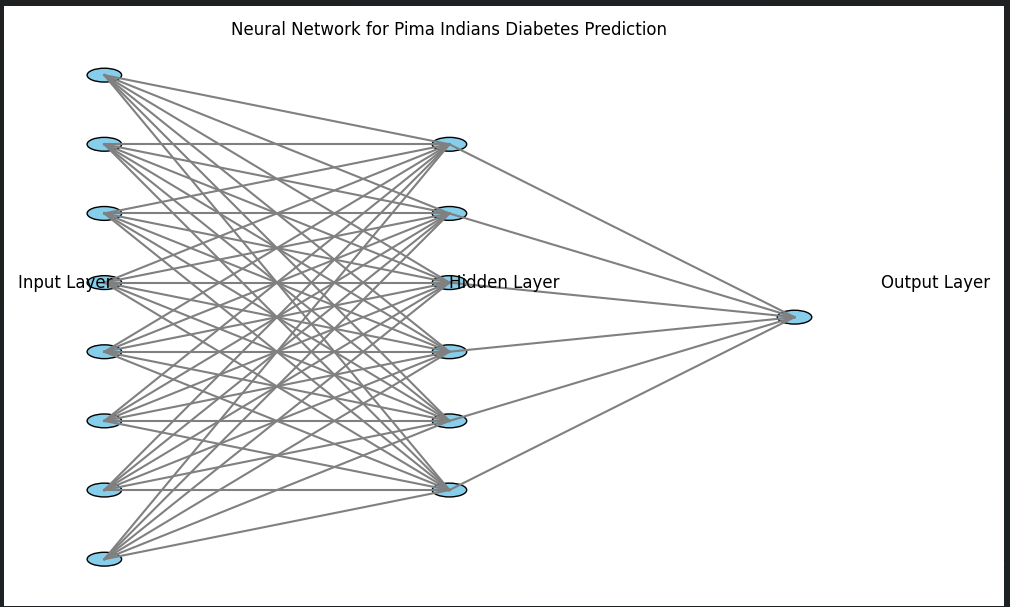

4. write a python program to draw the 3d plot for the model developed for house price prediction using suitable python based 3d plotting libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Step 1: Generate synthetic data
np.random.seed(0)
square_footage = np.random.randint(500, 3500, 100)
bedrooms = np.random.randint(1, 6, 100)
house_price = 50000 + 100 * square_footage + 20000 * bedrooms + np.random.normal(0, 20000, 100)

# Step 2: Prepare the feature matrix and target vector
X = np.column_stack((square_footage, bedrooms))
y = house_price

# Step 3: Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 4: Create a meshgrid for plotting
sf_range = np.linspace(square_footage.min(), square_footage.max(), 50)
br_range = np.linspace(bedrooms.min(), bedrooms.max(), 50)
sf_grid, br_grid = np.meshgrid(sf_range, br_range)
X_grid = np.column_stack((sf_grid.ravel(), br_grid.ravel()))
y_pred_grid = model.predict(X_grid).reshape(sf_grid.shape)

# Step 5: Plot the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(sf_grid, br_grid, y_pred_grid, cmap='viridis', alpha=0.7)
ax.scatter(square_footage, bedrooms, house_price, color='red', label='Actual Data')
ax.set_xlabel('Square Footage')
ax.set_ylabel('Number of Bedrooms')
ax.set_zlabel('House Price')
ax.set_title('3D Plot of House Price Prediction Model')
plt.legend()
plt.tight_layout()
plt.show()
